In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats #통계 패키지
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score #군집이 어느정도 정확성이 있는지 확인, 통계지표를 기반으로 평가

## Q1. 'dbscan.csv' 파일을 Pandas를 사용해서 읽고, 인덱스를 날짜 타입으로 변환하세요.

`` 시계열 데이터 ``
- x축이 시계열이면 시계열데이터임
- 데이터의 80%는 시계열 데이터임
- 독립변인이 연속값이면 시계열데이터로 바뀜--?

In [117]:
df = pd.read_csv('data/dbscan.csv') # 데이터 읽기
df['Date'] = pd.to_datetime(df['Date']) # 'Date'타입 변경 
                                        # ❗시계열은 계산(공휴일..)하기 어렵기 때문에 판다스에서 제공하는 기능을 쓰기위해서 date타입 변경 필요
df = df.set_index('Date') # 'Date'인덱스 설정, 'inplace=True'쓰지마라
df.shape

(1227, 7)

## Q2. 결측치가 몇개인지 확인하고, 선형 보간법과 채우기 기법(ffill, bfill)을 사용해서 결측치를 처리하세요.

In [118]:
# 방법1. interpolate(): 기울기값을 이용해서 채움
df =df.interpolate(method='linear')  #결측치를 적당히 보관해줌
df.isnull().sum()

KOSPI          0
S&P 500        0
Gold           0
Oil(WTI)       0
US 10Y Bond    0
KRW/USD        0
JPY/USD        0
dtype: int64

In [119]:
# 방법2. ffill():  
# df = df.ffill()
# df.isnull().sum()

## Q3. 이상치를 찾아보세요

In [120]:
def remove_outliers(data, threshhold = 3):
    z_score = stats.zscore(df) # 부호는 큰 의미없음
    abs_z_score = np.abs(z_score) #부호를 없앰(절댓값)
    filtered_entries = (abs_z_score < 3).all(axis=1) #z_score값이 3을 넘어가면 이상치라고 설정(magic num)
    return df[filtered_entries] # 이상치가 없어진 데이터

In [121]:
df_no_outliers = remove_outliers(df)
df_no_outliers.shape

(1204, 7)

In [122]:
returns = np.log(df_no_outliers / df_no_outliers.shift(1)).dropna() # ❗현재날짜/앞의 날짜 (맨 첫날은 None) ##log로 숫자 크기조정 ## 판다스에서는 for문돌리면 안된다(웬만하면)
returns # 수익률

,KOSPI,S&P 500,Gold,Oil(WTI),US 10Y Bond,KRW/USD,JPY/USD
Date,,,,,,,
2020-05-18,0.005087,0.031015,-0.012395,0.078080,-0.005285,0.005396,-0.001463
2020-05-19,0.022208,-0.010540,0.007135,0.021145,0.001915,-0.006424,0.001612
2020-05-20,0.004549,0.016514,0.003663,0.030007,0.001574,0.000098,0.003987
2020-05-21,0.004348,-0.007804,-0.017344,0.012758,-0.000112,0.001820,-0.002033
2020-05-22,-0.014202,0.002351,0.008162,-0.019950,0.000674,0.005561,0.000372
...,...,...,...,...,...,...,...
2025-04-03,-0.007676,-0.049606,-0.013757,-0.068684,0.010178,-0.002677,-0.012841
2025-04-04,-0.008594,-0.061609,-0.027830,-0.076973,0.003600,-0.010532,-0.011159
2025-04-07,-0.057267,-0.002334,-0.020359,-0.021029,-0.008746,0.005390,-0.005472


In [123]:
returns.corr() # ❗상관관계 확인하자 ## '-'값은 상관이 없다는것

,KOSPI,S&P 500,Gold,Oil(WTI),US 10Y Bond,KRW/USD,JPY/USD
KOSPI,1.000000,0.172809,0.095710,0.108023,-0.039549,-0.227364,-0.039115
S&P 500,0.172809,1.000000,0.127916,0.213356,0.030067,0.004462,0.038287
Gold,0.095710,0.127916,1.000000,0.158151,0.322277,-0.052023,-0.016027
Oil(WTI),0.108023,0.213356,0.158151,1.000000,-0.134845,0.002872,-0.018639
US 10Y Bond,-0.039549,0.030067,0.322277,-0.134845,1.000000,-0.075953,-0.053213
KRW/USD,-0.227364,0.004462,-0.052023,0.002872,-0.075953,1.000000,0.361346
JPY/USD,-0.039115,0.038287,-0.016027,-0.018639,-0.053213,0.361346,1.000000


## Q4. 스케일을 조정하세요

In [124]:
scaler = RobustScaler() #숫자가 작고 혹시 모를 이상치를 대비하기위해 Robust사용
scaler_returns = scaler.fit_transform(returns)

## Q5. KMeans의 K를 찾아보세요.

In [125]:
# 관측대상
inertia = []
silhoustte_scores = [] 
k_range = range(2, 10)

# k값이 중요!
for k in k_range:
    # KMeans 매개변수 설정
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42) #n_init: 초기 중심위치 시도 횟수
    
    # 예측
    kmeans_lables = kmeans.fit_predict(scaler_returns)
    
    # silhousette_scores를 측정 -> 숫자가 높으면 좋음
    inertia.append(kmeans.inertia_)
    silhoustte_scores.append(silhouette_score(scaler_returns, kmeans_lables))

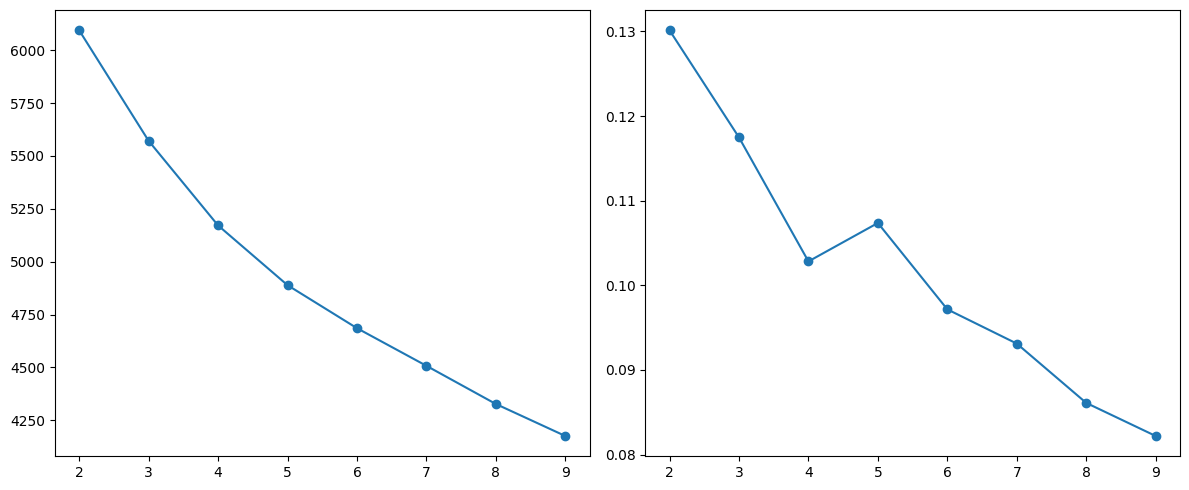

In [126]:
plt.figure(figsize=(12, 5))
# inertia
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')

# silhoustte_scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhoustte_scores, 'o-')
plt.tight_layout()
plt.show()
# 5정도면 합리적이다

## Q6. DBSCAN

In [127]:
eps_range = np.arange(0.3, 1.5, 0.1)
min_samples_range = [3, 5, 7, 10]
best_silhouette = -1
best_eps = 0
best_min_samples = 0

In [128]:
for eps in eps_range:
    for min_samples in min_samples_range:
        # DBSCAN 군집기 설정
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        
        # 예측
        dbscan_labels = dbscan.fit_predict(scaler_returns)
        
        # 최소한 클러스터는 1개 이상, 모든 포인트가 -1(no이 아니면 좋겠음
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) 
        if n_clusters > 1 and np.sum(dbscan_labels != -1) > 10:
            n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) # -1(noise)이 포함되어있으면 빼겠다
                                                                        #사실 noise는 없는게 맞음, 비지도니까!!!!!!!!!
        if n_clusters > 1 and np.sum(dbscan_labels != -1) > 10:
            non_noise_idx = dbscan_labels != -1
            if np.sum(non_noise_idx) > 1:
                score = silhouette_score(scaler_returns[non_noise_idx], dbscan_labels[non_noise_idx])
                if score > best_silhouette:
                    best_silhouette = score
                    best_eps = eps
                    best_min_samples = min_samples

In [129]:
print(best_silhouette, best_eps, best_min_samples)

0.3520712827086478 0.5 3


In [130]:
kmeans = KMeans(n_clusters= 5, n_init=10, random_state= 42)
kmeans_lables = kmeans.fit_predict(scaler_returns)


In [131]:
dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(scaler_returns)

In [132]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaler_returns)

In [ ]:
#kmean은 k를 우리가 정함
#dbscan은 7개를 9개로 분류한거임

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\numpy\_core\_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


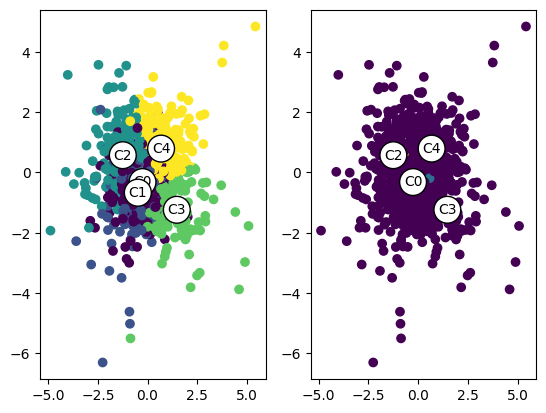

In [139]:
plt.subplot(1, 2, 1)
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=kmeans_lables, cmap='viridis')
for i in range(5):
    mask = kmeans_lables == i
    center = np.mean(pca_components[mask], axis=0)
    plt.annotate(
        f'C{i}',
        xy=center,
        ha='center',
        va='center',
        bbox = dict(boxstyle='circle', fc='white', ec='black')
    )

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=dbscan_labels, cmap='viridis')
for i in set(dbscan_labels):
    if i != 1:
        mask = kmeans_lables == i
        center = np.mean(pca_components[mask], axis=0)
        plt.annotate(
            f'C{i}',
            xy=center,
            ha='center',
            va='center',
            bbox = dict(boxstyle='circle', fc='white', ec='black')
    )

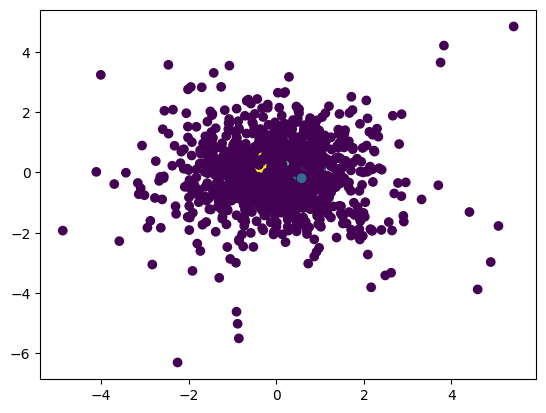